### Plotly

In [11]:
import plotly.graph_objects as go
import plotly.io as pio

# Define the updated HorizonAnalytics template
HorizonAnalytics = go.layout.Template(
    layout=go.Layout(
        paper_bgcolor='#0d1b2a',  # Background color
        plot_bgcolor='#0d1b2a',  # Background color
        height=800,
        width=800 * 1.618,
        xaxis=dict(
            anchor='y',
            showgrid=True,
            gridcolor='rgba(255, 255, 255, 0.2)',  # Softer grid lines for contrast
            tickfont=dict(
                size=36,  # Consistent with other elements
                family='Montserrat, sans-serif',
                color='#ffffff',
                weight="bold"
            ),
            title=dict(
                text='',
                font=dict(
                    size=48,  # Increase to match other elements
                    family='Montserrat, sans-serif',
                    color='#ffffff',
                    weight="bold"
                )
            ),
            linecolor='#ffffff',  # White axis lines for contrast
            linewidth=2
        ),
        yaxis=dict(
            anchor='x',
            showgrid=True,
            gridcolor='rgba(255, 255, 255, 0.2)',  # Softer grid lines
            tickfont=dict(
                size=36,  # Consistent with x-axis
                family='Montserrat, sans-serif',
                color='#ffffff',
                weight="bold"
            ),
            title=dict(
                text='',
                font=dict(
                    size=48,  # Increase to match x-axis
                    family='Montserrat, sans-serif',
                    color='#ffffff',
                    weight="bold"
                )
            ),
            linecolor='#ffffff',  # White axis lines
            linewidth=2
        ),
        font=dict(
            color='#ffffff',  # White font for all text
            size=36,  # Uniform font size
            family='Montserrat, sans-serif',
            weight="bold"
        ),
        # Refined colorway for better visibility and differentiation
        colorway=["#FFFF00", "#33D7FF", "#A463FF", "#FFD700", 
                  "#ff4081", "#ffc107", "#00c4a0", "#a0aec0"],
        title=dict(
            text='',
            font=dict(
                size=64,  # **Big Boost in Title Size**
                color='#ffffff',
                family='Montserrat, sans-serif',
                weight="bold"
            ),
            x=0.5,  # Center title
            y=0.97  # Push title higher
        )
    ),
    data=dict(
        scatter=[
            go.Scatter(
                line=dict(width=5)  # Increased line width for better visibility
            )
        ]
    )
)

# Register the updated HorizonAnalytics template
pio.templates['HorizonAnalytics'] = HorizonAnalytics
pio.templates.default = 'HorizonAnalytics'

#### https://plotly.com/python/builtin-colorscales/
#### https://www.who.int/data/gho/data/indicators/indicator-details/GHO/prevalence-of-obesity-among-adults-bmi--30-(age-standardized-estimate)-(-)6
#### https://github.com/johan/world.geo.json
#### https://pacific-data.sprep.org/dataset/pacific-island-region-spatial-data
#### https://github.com/topojson/world-atlas/blob/master/README.md

In [12]:
import pandas as pd

# Load raw data
df_raw = pd.read_csv("f_obesity_raw.csv")

# Filter for latest year and both sexes
df_filtered = df_raw[
    (df_raw["IsLatestYear"] == True) &
    (df_raw["Dim1ValueCode"] == "SEX_BTSX")
]

# Select relevant columns and rename
d_country_obesity = df_filtered[[
    "SpatialDimValueCode",  # Country code (ISO alpha-3)
    "Location",             # Country name
    "Period",               # Year
    "FactValueNumeric"      # Obesity rate
]].rename(columns={
    "SpatialDimValueCode": "country_code",
    "Location": "country_name",
    "Period": "year",
    "FactValueNumeric": "obesity_rate"
})

# Reset index for cleanliness
d_country_obesity.reset_index(drop=True, inplace=True)

# Save to CSV
d_country_obesity.to_csv("d_country_obesity.csv", index=False)

# Optional: preview
print(d_country_obesity.head())

  country_code                           country_name  year  obesity_rate
0          SEN                                Senegal  2022         10.21
1          MOZ                             Mozambique  2022         10.26
2          LKA                              Sri Lanka  2022         10.56
3          HTI                                  Haiti  2022         10.69
4          PRK  Democratic People's Republic of Korea  2022         10.80


## tidy_country_names()

In [13]:
import pandas as pd

def tidy_country_names(csv_path):
    # Define the country name replacements
    replacements = {
        "Democratic People's Republic of Korea": "North Korea",
        "United Republic of Tanzania": "Tanzania",
        "Netherlands (Kingdom of the)": "Netherlands",
        "Venezuela (Bolivarian Republic of)": "Venezuela",
        "Iran (Islamic Republic of)": "Iran",
        "United Kingdom of Great Britain and Northern Ireland": "United Kingdom",
        "Bolivia (Plurinational State of)": "Bolivia",
        "Syrian Arab Republic": "Syria",
        "occupied Palestinian territory, including east Jerusalem": "Palestine",
        "Micronesia (Federated States of)": "Micronesia",
        "Democratic Republic of the Congo": "DR Congo",
        "Republic of Korea": "South Korea",
        "Lao People's Democratic Republic": "Lao",
        "Viet Nam": "Vietnam",
        "Russian Federation": "Russia",
        "United States of America": "United States",
        "Republic of Moldova": "Moldova",
        "Saint Vincent and the Grenadines": "St. Vincent & Grenadines"
    }

    # Read CSV
    df = pd.read_csv(csv_path)

    # Replace country names
    df["country_name"] = df["country_name"].replace(replacements)

    # Overwrite CSV
    df.to_csv(csv_path, index=False)

    print(f"✅ Tidied and saved: {csv_path}")

tidy_country_names("d_country_obesity.csv")

✅ Tidied and saved: d_country_obesity.csv


## order_csv()

In [19]:
import pandas as pd

def order_csv(csv_path, column_name, direction="asc"):
    # Read the CSV
    df = pd.read_csv(csv_path)

    # Check sort direction
    ascending = True if direction.lower() == "asc" else False

    # Sort the DataFrame
    df_sorted = df.sort_values(by=column_name, ascending=ascending)

    # Save back to the same file
    df_sorted.to_csv(csv_path, index=False)

    print(f"✅ Sorted by '{column_name}' ({direction}) and saved: {csv_path}")

order_csv("d_country_obesity.csv", column_name="obesity_rate", direction="asc")

✅ Sorted by 'obesity_rate' (asc) and saved: d_country_obesity.csv


## load_world_geojson()

In [16]:
import geopandas as gpd
import requests

def load_world_geojson(source='local'):
    """
    Load world map from a local simplified GeoJSON or a simplified online version.

    Parameters:
        source (str): 'local' or 'web'

    Returns:
        GeoDataFrame or dict: GeoDataFrame if local, dict if web
    """
    if source == 'local':
        local_geojson_path = "../ne_10m_admin_0_countries_lakes/world_simplified.geojson"
        try:
            print(f"📁 Loading local simplified GeoJSON from: {local_geojson_path}")
            return gpd.read_file(local_geojson_path)
        except FileNotFoundError:
            raise FileNotFoundError(f"❌ GeoJSON file not found at: {local_geojson_path}")

    elif source == 'web':
        print("🌍 Loading simplified GeoJSON from Johan's GitHub...")
        geojson_url = "https://raw.githubusercontent.com/johan/world.geo.json/master/countries.geo.json"
        response = requests.get(geojson_url)
        response.raise_for_status()
        return response.json()

    else:
        raise ValueError("Invalid source. Use 'local' or 'web'.")

# Example usage:
world_geojson = load_world_geojson('web')  # or 'web'

🌍 Loading simplified GeoJSON from Johan's GitHub...


## map_frames ()

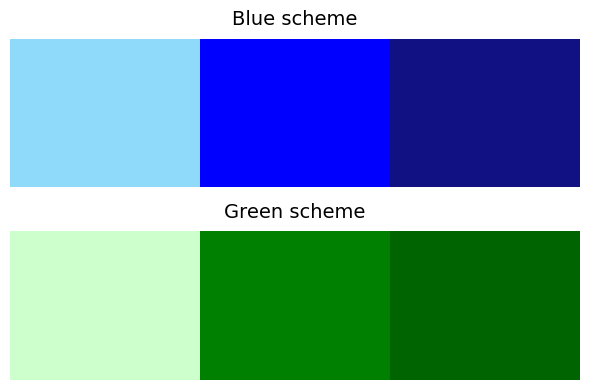

In [3]:
color_schemes = {
    "blue": {
        "color_min": "143,217,251",  # light blue
        "color_mid": "0,0,255",      # medium blue
        "color_max": "17,17,132"     # dark blue
    },
    "red": {
        "color_min": "255,255,153",  # light yellow
        "color_mid": "255,165,0",    # orange
        "color_max": "204,0,0"       # dark red
    },
    "green": {
        "color_min": "204,255,204",  # light green
        "color_mid": "0,128,0",      # medium green
        "color_max": "0,100,0"       # dark green
    },
    "purple": {
        "color_min": "221,160,221",  # light purple
        "color_mid": "128,0,128",    # medium purple
        "color_max": "75,0,130"      # dark purple
    }
}


def show_color_schemes(schemes=None):
    import matplotlib.pyplot as plt

    if schemes is None:
        schemes = color_schemes.keys()
    elif isinstance(schemes, str):
        schemes = [schemes]

    selected_schemes = {k: v for k, v in color_schemes.items() if k in schemes}

    fig, axes = plt.subplots(nrows=len(selected_schemes), figsize=(6, 2 * len(selected_schemes)))
    if len(selected_schemes) == 1:
        axes = [axes]  # Ensure axes is iterable

    for ax, (name, scheme) in zip(axes, selected_schemes.items()):
        colors = [tuple(map(int, c.split(','))) for c in scheme.values()]
        colors = [[(r / 255, g / 255, b / 255) for r, g, b in colors]]

        ax.imshow(colors, aspect='auto')
        ax.set_title(f'{name.capitalize()} scheme', fontsize=14, pad=10)
        ax.axis('off')

    plt.tight_layout()
    plt.show()


# Example usage
show_color_schemes(['blue', 'green'])

In [26]:
import pandas as pd
import plotly.graph_objects as go
import os
import shutil

def map_frames(
    csv_filename,
    world_geojson,
    metric='obesity_rate',
    plot_height=1080,
    plot_width=1920,
    color_min='255,255,0',
    color_mid='255,165,0',
    color_max='255,0,0',
    parent_folder='2023-03_obesity',
    output_folder='frames_world',
    clear=True,
    zoom=None,
    marker_size=10,
    min_color_percentile=5,
    max_color_percentile=95
):
    # Adjust output folder if zooming
    if zoom:
        output_folder += f"_{zoom.lower()}"

    # Load data
    df = pd.read_csv(csv_filename)
    latest_year = df['year'].max()
    df = df[df['year'] == latest_year].reset_index(drop=True)

    # Compute color scale values based on input percentiles
    color_min_value = df[metric].quantile(min_color_percentile / 100)
    color_max_value = df[metric].quantile(max_color_percentile / 100)
    color_mid_value = df[metric].mean()
    
    # 👇 Add this to print the legend values
    print(f"🎨 Color scale range for '{metric}':")
    print(f"   Min (p{min_color_percentile}): {color_min_value:.2f}")
    print(f"   Mid (mean): {color_mid_value:.2f}")
    print(f"   Max (p{max_color_percentile}): {color_max_value:.2f}")
    geojson = world_geojson

    all_countries = pd.DataFrame({
        'country_code': [
            feature.get('id') or feature['properties'].get('iso_a3')
            for feature in geojson['features']
        ]
    })

    # Define small countries (edit this to add/remove)
    small_countries_coords = {
        'TON': (-21.2, -175.2),
        'WSM': (-13.8, -172.1),
        'NRU': (-0.52, 166.93),
        'KIR': (1.87, 173.0),
        'PLW': (7.5, 134.5),
        'MHL': (7.1, 171.0),
        'FSM': (6.9, 158.2),
        'VUT': (-16.0, 167.0),
        'TUV': (-7.1, 179.2),
        'NIU': (-19.05, -169.86),
        'COK': (-21.2, -159.8),
        'TKL': (-9.2, -171.8),
        'ASM': (-14.3, -170.7),
        'CPV': (15.1, -23.6),
        'STP': (0.2, 6.6),
        'COM': (-11.6, 43.3),
        'LUX': (49.8, 6.1),
        'AND': (42.5, 1.5),
        'LCA': (13.9, -60.98),
        'ATG': (17.1, -61.8),
        'DMA': (15.4, -61.4),
        'VCT': (13.25, -61.2),
        'KNA': (17.3, -62.7),
        'BRB': (13.1, -59.6),
        'BMU': (32.3, -64.8),
        'MDV': (3.2, 73.2),
        'SGP': (1.35, 103.8),
        'BHR': (26.0, 50.5),
        'QAT': (25.3, 51.5),
        'DJI': (11.8, 42.6),
        'GMB': (13.5, -15.5),
        'SYC': (-4.6, 55.5),
        'MUS': (-20.2, 57.5),
        'GNQ': (1.6, 10.5),
        'GNB': (11.8, -15.2),
        'SLB': (-9.6, 160.2),
        'PYF': (-17.6797, -149.4068)  # French Polynesia (Tahiti approx.)
    }

    small_countries = pd.DataFrame([
        {'country_code': code, 'lat': lat, 'lon': lon}
        for code, (lat, lon) in small_countries_coords.items()
    ])

    # Set output path
    output_path = f"/Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/{parent_folder}/{output_folder}"
    if clear and os.path.exists(output_path):
        shutil.rmtree(output_path)
    os.makedirs(output_path, exist_ok=True)

    for i in range(1, len(df) + 1):
        df_partial = df.iloc[:i]
        df_merged = all_countries.merge(
            df_partial[['country_code', 'country_name', metric]],
            on='country_code', how='left'
        )

        # Merge small countries with current values
        small_data = small_countries.merge(
            df_partial[['country_code', metric]],
            on='country_code',
            how='left'
        )

        fig = go.Figure()

        # Choropleth with clipped values
        choropleth_values = df_merged[metric].copy()
        choropleth_values[df_merged[metric] > color_max_value] = None  # hide outliers

        fig.add_trace(go.Choropleth(
            geojson=geojson,
            locations=df_merged['country_code'],
            z=choropleth_values,
            locationmode='ISO-3',
            colorscale=[
                [0.0,     f'rgb({color_min})'],
                [0.5,     f'rgb({color_mid})'],
                [1.0,     f'rgb({color_max})']
            ],
            zmin=color_min_value,
            zmax=color_max_value,
            colorbar_title=metric.replace("_", " ").capitalize(),
            text=df_merged['country_name'],
            hoverinfo='location+z+text',
            marker_line_color='white',
            marker_line_width=1.5,
        ))

        # Overlay outliers in custom RGB
        outlier_color = 'rgb(60,0,8)'
        outlier_countries = df_merged[df_merged[metric] > color_max_value]['country_code'].tolist()
        if outlier_countries:
            fig.add_trace(go.Choropleth(
                geojson=geojson,
                locations=outlier_countries,
                z=[1] * len(outlier_countries),
                locationmode='ISO-3',
                colorscale=[[0, outlier_color], [1, outlier_color]],
                zmin=0, zmax=1,
                showscale=False,
                marker_line_color='white',
                marker_line_width=1.5,
                hoverinfo='skip'
            ))

        # Marker color logic
        marker_colors = [
            outlier_color if pd.notna(val) and val > color_max_value else val
            for val in small_data[metric]
        ]

        fig.add_trace(go.Scattergeo(
            lon=small_data['lon'],
            lat=small_data['lat'],
            mode='markers',
            marker=dict(
                size=marker_size,
                color=marker_colors,
                colorscale=[
                    [0.0, 'rgba(0,0,0,0)'],
                    [0.00001, f'rgb({color_min})'],
                    [0.5,     f'rgb({color_mid})'],
                    [1.0,     f'rgb({color_max})']
                ],
                cmin=color_min_value,
                cmax=color_max_value,
                colorbar=None,
                line=dict(width=0.5, color='white'),
                opacity=small_data[metric].notna().astype(float)
            ),
            hoverinfo='skip',
            showlegend=False
        ))

        # Geo settings
        if zoom == 'Europe':
            fig.update_geos(
                showcountries=True,
                countrycolor="white",
                showframe=False,
                showcoastlines=False,
                showlakes=False,
                bgcolor='rgba(0,0,0,0)',
                center={"lat": 55, "lon": 15},
                projection_scale=4
            )
        else:
            fig.update_geos(
                showcountries=True,
                countrycolor="white",
                showframe=False,
                showcoastlines=False,
                showlakes=False,
                bgcolor='rgba(0,0,0,0)',
                lataxis_range=[-60, 90],
                projection_rotation={"lon": 40}
            )

        fig.update_layout(
            margin={"r": 0, "t": 0, "l": 0, "b": 0},
            paper_bgcolor='rgba(0,0,0,0)',
            plot_bgcolor='rgba(0,0,0,0)',
            height=plot_height,
            width=plot_width,
            coloraxis_colorbar=dict(
                len=0.5,
                yanchor='middle',
                y=0.5
            )
        )

        # Save frame
        filepath = f"{output_path}/{i:04d}.png"
        fig.write_image(filepath, scale=1)

        current_country = df_partial.iloc[-1]['country_name']
        print(f"✅ Saved {filepath} – added: {current_country}")

#### Validate every country

In [27]:
map_frames(
    csv_filename="d_country_obesity.csv",
    world_geojson=world_geojson,
    metric="obesity_rate",
    plot_height=1080,
    plot_width=1920,
    color_min="255,255,153",
    color_mid="255,165,0",
    color_max="204,0,0",
    parent_folder="2023-03_obesity",
    output_folder="frames_world",
    clear=True,
    zoom=None,
    marker_size=12,
    min_color_percentile=3,
    max_color_percentile=95
)

🎨 Color scale range for 'obesity_rate':
   Min (p3): 4.91
   Mid (mean): 24.28
   Max (p95): 47.12
✅ Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_obesity/frames_world/0001.png – added: Vietnam
✅ Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_obesity/frames_world/0002.png – added: Timor-Leste
✅ Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_obesity/frames_world/0003.png – added: Ethiopia
✅ Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_obesity/frames_world/0004.png – added: Madagascar
✅ Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_obesity/frames_world/0005.png – added: Cambodia
✅ Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_obesity/frames_world/0006.png – added: Eritrea
✅ Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_obesity/frames_world/0007.png – added: Rwanda
✅ Saved /Users/arya/Documents/Adobe/Pre

## text_frames (dataframe, output_folder, font_folder, font_size, font_type)

In [1]:
from PIL import Image, ImageDraw, ImageFont
import pandas as pd
import os
import shutil

def interpolate_color(val, min_val, mid_val, max_val, rgb_min, rgb_mid, rgb_max):
    if val <= mid_val:
        ratio = (val - min_val) / (mid_val - min_val) if mid_val > min_val else 0
        return tuple([
            int(rgb_min[i] + ratio * (rgb_mid[i] - rgb_min[i]))
            for i in range(3)
        ])
    else:
        ratio = (val - mid_val) / (max_val - mid_val) if max_val > mid_val else 0
        return tuple([
            int(rgb_mid[i] + ratio * (rgb_max[i] - rgb_mid[i]))
            for i in range(3)
        ])

def extract_text(
    csv_filename,
    parent_folder='2023-03_obesity',
    output_folder='frames_text',
    output_folder_suffix='',
    metric='obesity_rate',
    font_type='ExtraBold',
    font_size=100,
    image_width=1920,
    image_height=1080,
    alignment='center',  # 'left', 'center', or 'right'
    color_min='255,255,0',
    color_mid='255,165,0',
    color_max='255,0,0',
    min_color_percentile=5,
    max_color_percentile=95,
    clear=True
):
    # Parse colors
    rgb_min = tuple(map(int, color_min.split(',')))
    rgb_mid = tuple(map(int, color_mid.split(',')))
    rgb_max = tuple(map(int, color_max.split(',')))
    rgb_outlier = (128, 0, 0)
    outline_color_regular = (0, 0, 0)
    outline_color_outlier = (180, 180, 180)

    # Output path
    full_output_folder = output_folder + output_folder_suffix
    output_path = os.path.join(
        "/Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics",
        parent_folder,
        full_output_folder
    )
    if clear and os.path.exists(output_path):
        shutil.rmtree(output_path)
    os.makedirs(output_path, exist_ok=True)

    # Load and filter data
    df = pd.read_csv(csv_filename)
    latest_year = df['year'].max()
    df = df[df['year'] == latest_year].reset_index(drop=True)

    # Compute thresholds
    color_min_value = df[metric].quantile(min_color_percentile / 100)
    color_max_value = df[metric].quantile(max_color_percentile / 100)
    color_mid_value = df[metric].mean()

    # Add ranks (doesn't change order)
    df['rank'] = df[metric].rank(method='min', ascending=False).astype(int)

    # Load font
    font_path = os.path.join("..", "Montserrat", f"Montserrat-{font_type}.ttf")
    try:
        font = ImageFont.truetype(font_path, font_size)
    except IOError:
        print(f"Montserrat font '{font_type}' not found. Using default font.")
        font = ImageFont.load_default()

    for i in range(1, len(df) + 1):
        row = df.iloc[i - 1]
        country = row['country_name']
        rate = round(row[metric], 1)
        rank = row['rank']
        is_outlier = rate > color_max_value

        text = f"#{rank}. {country.upper()}\n{metric.replace('_', ' ').upper()}: {rate}%"
        text_color = rgb_outlier if is_outlier else interpolate_color(
            rate, color_min_value, color_mid_value, color_max_value,
            rgb_min, rgb_mid, rgb_max
        )
        outline_color = outline_color_outlier if is_outlier else outline_color_regular

        # Create transparent image
        img = Image.new('RGBA', (image_width, image_height), (0, 0, 0, 0))
        draw = ImageDraw.Draw(img)

        # Measure text
        bbox = draw.multiline_textbbox((0, 0), text, font=font, spacing=20)
        text_width = bbox[2] - bbox[0]
        y = 0

        if alignment == 'left':
            x = 100
        elif alignment == 'right':
            x = image_width - text_width - 100
        else:
            x = (image_width - text_width) / 2

        # Draw outline
        offset = 4
        for dx in [-offset, 0, offset]:
            for dy in [-offset, 0, offset]:
                if dx == 0 and dy == 0:
                    continue
                draw.multiline_text((x + dx, y + dy), text, font=font, fill=outline_color, spacing=20)

        # Draw main text
        draw.multiline_text((x, y), text, font=font, fill=text_color, spacing=20, align=alignment)

        filepath = os.path.join(output_path, f"{i:04d}.png")
        img.save(filepath)
        print(f"🖼️ Saved {filepath} – added: {country} (#{rank})")

In [2]:
extract_text(
    csv_filename='d_country_obesity.csv',
    parent_folder='2023-03_obesity',
    output_folder='frames_text',
    output_folder_suffix='',
    metric='obesity_rate',
    font_type='ExtraBold',
    font_size=100,
    image_width=2320,
    image_height=1080,
    alignment='left',  # 'left', 'center', or 'right'
    color_min="255,255,153",
    color_mid="255,165,0",
    color_max="204,0,0",
    min_color_percentile=3,
    max_color_percentile=95,
    clear=True
)

🖼️ Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_obesity/frames_text/0001.png – added: Vietnam (#199)
🖼️ Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_obesity/frames_text/0002.png – added: Timor-Leste (#198)
🖼️ Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_obesity/frames_text/0003.png – added: Ethiopia (#197)
🖼️ Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_obesity/frames_text/0004.png – added: Madagascar (#196)
🖼️ Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_obesity/frames_text/0005.png – added: Cambodia (#195)
🖼️ Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_obesity/frames_text/0006.png – added: Eritrea (#194)
🖼️ Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_obesity/frames_text/0007.png – added: Rwanda (#193)
🖼️ Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_obesity/frame

In [5]:
import pandas as pd
import os
import shutil
import requests
from PIL import Image
from io import BytesIO
from pycountry import countries

def save_flag_frames(
    csv_filename,
    parent_folder='2023-03_obesity',
    output_folder='frames_flag',
    image_width=1920,
    image_height=1080,
    clear=True
):
    # Output path
    output_path = os.path.join(
        "/Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics",
        parent_folder,
        output_folder
    )

    if clear and os.path.exists(output_path):
        shutil.rmtree(output_path)
    os.makedirs(output_path, exist_ok=True)

    # Load data and preserve original order
    df = pd.read_csv(csv_filename)
    latest_year = df['year'].max()
    df = df[df['year'] == latest_year].reset_index(drop=True)

    # Create ISO-3 to ISO-2 mapping
    iso_map = {c.alpha_3: c.alpha_2.lower() for c in countries if hasattr(c, 'alpha_3')}

    for i in range(len(df)):
        row = df.iloc[i]
        code3 = row['country_code']
        country = row['country_name']
        code2 = iso_map.get(code3)

        if not code2:
            print(f"⚠️ No ISO-2 code for {country} ({code3})")
            continue

        url = f"https://flagcdn.com/w320/{code2}.png"
        try:
            response = requests.get(url)
            response.raise_for_status()
            flag = Image.open(BytesIO(response.content)).convert("RGBA")
        except Exception as e:
            print(f"❌ Failed to load flag for {country} ({code3}): {e}")
            continue

        # Resize and center the flag on a transparent canvas
        flag_aspect = flag.width / flag.height
        target_height = image_height
        target_width = int(target_height * flag_aspect)
        flag = flag.resize((target_width, target_height), Image.LANCZOS)

        img = Image.new("RGBA", (image_width, image_height), (0, 0, 0, 0))
        x = (image_width - flag.width) // 2
        y = (image_height - flag.height) // 2
        img.paste(flag, (x, y), flag)

        filepath = os.path.join(output_path, f"{i+1:04d}.png")
        img.save(filepath)
        print(f"🏁 Saved {filepath} – {country}")

# Example usage
save_flag_frames(
    csv_filename='d_country_obesity.csv',
    parent_folder='2023-03_obesity',
    output_folder='frames_flag'
)

🏁 Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_obesity/frames_flag/0001.png – Vietnam
🏁 Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_obesity/frames_flag/0002.png – Timor-Leste
🏁 Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_obesity/frames_flag/0003.png – Ethiopia
🏁 Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_obesity/frames_flag/0004.png – Madagascar
🏁 Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_obesity/frames_flag/0005.png – Cambodia
🏁 Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_obesity/frames_flag/0006.png – Eritrea
🏁 Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_obesity/frames_flag/0007.png – Rwanda
🏁 Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_obesity/frames_flag/0008.png – Burundi
🏁 Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_obesi

## 1990

In [34]:
import pandas as pd

# Load raw data
df_raw = pd.read_csv("f_obesity_raw.csv")

# Filter for both sexes
df_both_sexes = df_raw[df_raw["Dim1ValueCode"] == "SEX_BTSX"]

# Function to extract data for a given year
def extract_obesity_by_year(df, year):
    df_year = df[df["Period"] == year][[
        "SpatialDimValueCode",  # Country code (ISO alpha-3)
        "Location",             # Country name
        "Period",               # Year
        "FactValueNumeric"      # Obesity rate
    ]].rename(columns={
        "SpatialDimValueCode": "country_code",
        "Location": "country_name",
        "Period": "year",
        "FactValueNumeric": "obesity_rate"
    })
    df_year.reset_index(drop=True, inplace=True)
    return df_year

# Generate and concatenate data for all years
all_years = df_both_sexes["Period"].unique()
df_list = [extract_obesity_by_year(df_both_sexes, year) for year in sorted(all_years)]

d_country_obesity_history = pd.concat(df_list, ignore_index=True)

# Save to CSV
d_country_obesity_history.to_csv("d_country_obesity_history.csv", index=False)

# Optional: preview
print(d_country_obesity_history.head())

  country_code country_name  year  obesity_rate
0          VNM     Viet Nam  1990          0.21
1          TLS  Timor-Leste  1990          0.28
2          BGD   Bangladesh  1990          0.33
3          ETH     Ethiopia  1990          0.36
4          KHM     Cambodia  1990          0.53


In [ ]:
tidy_country_names("d_country_obesity_history.csv")
order_csv("d_country_obesity_old.csv", column_name="obesity_rate", direction="asc")

In [51]:
def map_frames_hardcoded(
    csv_filename,
    world_geojson,
    year,
    index,
    metric='obesity_rate',
    plot_height=1080,
    plot_width=1920,
    parent_folder='2023-03_obesity',
    output_folder='frames_world',
    clear=False,
    zoom=None,
    marker_size=10
):
    import pandas as pd
    import plotly.graph_objects as go
    import os
    import shutil

    # Hardcoded color scale values
    color_min = "255,255,153"
    color_mid = "255,165,0"
    color_max = "204,0,0"
    color_min_value = 4.91
    color_mid_value = 24.28
    color_max_value = 47.12

    # Adjust output folder if zooming
    if zoom:
        output_folder += f"_{zoom.lower()}"

    # Load data
    df = pd.read_csv(csv_filename)
    df = df[df['year'] == year].reset_index(drop=True)

    geojson = world_geojson

    all_countries = pd.DataFrame({
        'country_code': [
            feature.get('id') or feature['properties'].get('iso_a3')
            for feature in geojson['features']
        ]
    })

    small_countries_coords = {
        'TON': (-21.2, -175.2), 'WSM': (-13.8, -172.1), 'NRU': (-0.52, 166.93), 'KIR': (1.87, 173.0),
        'PLW': (7.5, 134.5), 'MHL': (7.1, 171.0), 'FSM': (6.9, 158.2), 'VUT': (-16.0, 167.0),
        'TUV': (-7.1, 179.2), 'NIU': (-19.05, -169.86), 'COK': (-21.2, -159.8), 'TKL': (-9.2, -171.8),
        'ASM': (-14.3, -170.7), 'CPV': (15.1, -23.6), 'STP': (0.2, 6.6), 'COM': (-11.6, 43.3),
        'LUX': (49.8, 6.1), 'AND': (42.5, 1.5), 'LCA': (13.9, -60.98), 'ATG': (17.1, -61.8),
        'DMA': (15.4, -61.4), 'VCT': (13.25, -61.2), 'KNA': (17.3, -62.7), 'BRB': (13.1, -59.6),
        'BMU': (32.3, -64.8), 'MDV': (3.2, 73.2), 'SGP': (1.35, 103.8), 'BHR': (26.0, 50.5),
        'QAT': (25.3, 51.5), 'DJI': (11.8, 42.6), 'GMB': (13.5, -15.5), 'SYC': (-4.6, 55.5),
        'MUS': (-20.2, 57.5), 'GNQ': (1.6, 10.5), 'GNB': (11.8, -15.2), 'SLB': (-9.6, 160.2),
        'PYF': (-17.6797, -149.4068)
    }

    small_countries = pd.DataFrame([
        {'country_code': code, 'lat': lat, 'lon': lon}
        for code, (lat, lon) in small_countries_coords.items()
    ])

    output_path = f"/Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/{parent_folder}/{output_folder}"
    if clear and os.path.exists(output_path):
        shutil.rmtree(output_path)
    os.makedirs(output_path, exist_ok=True)

    df_merged = all_countries.merge(
        df[["country_code", "country_name", metric]],
        on="country_code", how="left"
    )

    small_data = small_countries.merge(
        df[["country_code", metric]],
        on="country_code", how="left"
    )

    fig = go.Figure()

    choropleth_values = df_merged[metric].copy()
    choropleth_values[df_merged[metric] > color_max_value] = None

    fig.add_trace(go.Choropleth(
        geojson=geojson,
        locations=df_merged['country_code'],
        z=choropleth_values,
        locationmode='ISO-3',
        colorscale=[
            [0.0,    f'rgb({color_min})'],
            [0.5,    f'rgb({color_mid})'],
            [1.0,    f'rgb({color_max})']
        ],
        zmin=color_min_value,
        zmax=color_max_value,
        colorbar_title=metric.replace("_", " ").capitalize(),
        text=df_merged['country_name'],
        hoverinfo='location+z+text',
        marker_line_color='white',
        marker_line_width=1.5,
    ))

    outlier_color = 'rgb(60,0,8)'
    outlier_countries = df_merged[df_merged[metric] > color_max_value]['country_code'].tolist()
    if outlier_countries:
        fig.add_trace(go.Choropleth(
            geojson=geojson,
            locations=outlier_countries,
            z=[1] * len(outlier_countries),
            locationmode='ISO-3',
            colorscale=[[0, outlier_color], [1, outlier_color]],
            zmin=0, zmax=1,
            showscale=False,
            marker_line_color='white',
            marker_line_width=1.5,
            hoverinfo='skip'
        ))

    marker_colors = [
        outlier_color if pd.notna(val) and val > color_max_value else val
        for val in small_data[metric]
    ]

    fig.add_trace(go.Scattergeo(
        lon=small_data['lon'],
        lat=small_data['lat'],
        mode='markers',
        marker=dict(
            size=marker_size,
            color=marker_colors,
            colorscale=[
                [0.0,    f'rgb({color_min})'],
                [0.5,    f'rgb({color_mid})'],
                [1.0,    f'rgb({color_max})']
            ],
            cmin=color_min_value,
            cmax=color_max_value,
            colorbar=None,
            line=dict(width=0.5, color='white'),
            opacity=small_data[metric].notna().astype(float)
        ),
        hoverinfo='skip',
        showlegend=False
    ))

    if zoom == 'Europe':
        fig.update_geos(
            showcountries=True,
            countrycolor="white",
            showframe=False,
            showcoastlines=False,
            showlakes=False,
            bgcolor='rgba(0,0,0,0)',
            center={"lat": 55, "lon": 15},
            projection_scale=4
        )
    else:
        fig.update_geos(
            showcountries=True,
            countrycolor="white",
            showframe=False,
            showcoastlines=False,
            showlakes=False,
            bgcolor='rgba(0,0,0,0)',
            lataxis_range=[-60, 90],
            projection_rotation={"lon": 40}
        )

    fig.update_layout(
        margin={"r": 0, "t": 0, "l": 0, "b": 0},
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)',
        height=plot_height,
        width=plot_width,
        coloraxis_colorbar=dict(
            len=0.5,
            yanchor='middle',
            y=0.5
        )
    )

    filepath = f"{output_path}/{index:04d}.png"
    fig.write_image(filepath, scale=1)
    print(f"✅ Saved {filepath} for year {year}")

In [53]:
import pandas as pd
import json

# Set file path and read dataset
csv_filename = "d_country_obesity_history.csv"
df = pd.read_csv(csv_filename)

# Get all unique years in order
years = sorted(df["year"].dropna().unique())

# Generate one map per year
for i, year in enumerate(years, start=1):
    map_frames_hardcoded(
        csv_filename="d_country_obesity_history.csv",
        world_geojson=world_geojson,
        year=year,
        index=i,
        metric="obesity_rate",
        plot_height=1080,
        plot_width=1920,
        parent_folder="2023-03_obesity",
        output_folder="frames_world_history",
        clear=False,  # important to avoid deleting output folder each time
        zoom=None,
        marker_size=12
    )


✅ Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_obesity/frames_world_history/0001.png for year 1990
✅ Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_obesity/frames_world_history/0002.png for year 1991
✅ Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_obesity/frames_world_history/0003.png for year 1992
✅ Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_obesity/frames_world_history/0004.png for year 1993
✅ Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_obesity/frames_world_history/0005.png for year 1994
✅ Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_obesity/frames_world_history/0006.png for year 1995
✅ Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_obesity/frames_world_history/0007.png for year 1996
✅ Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_obesity/frames_world_history/0008.pn

In [47]:
from PIL import Image, ImageDraw, ImageFont
import pandas as pd
import os
import shutil

def extract_text_all_years(
    csv_filename,
    parent_folder='2023-03_obesity',
    output_folder='frames_years_only',
    font_type='ExtraBold',
    font_size=200,
    image_width=1920,
    image_height=1080,
    alignment='center',
    clear=True
):
    # Colors
    text_color = (0, 0, 0)  # black
    outline_color = (255, 255, 255)  # white

    # Output path
    output_path = os.path.join(
        "/Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics",
        parent_folder,
        output_folder
    )
    if clear and os.path.exists(output_path):
        shutil.rmtree(output_path)
    os.makedirs(output_path, exist_ok=True)

    # Load data
    df = pd.read_csv(csv_filename)

    # Load font
    font_path = os.path.join("..", "Montserrat", f"Montserrat-{font_type}.ttf")
    try:
        font = ImageFont.truetype(font_path, font_size)
    except IOError:
        print(f"Montserrat font '{font_type}' not found. Using default font.")
        font = ImageFont.load_default()

    # Unique years (reverse order)
    years = sorted(df['year'].unique(), reverse=True)

    for i, year in enumerate(years, start=1):
        text = str(year)

        # Create transparent image
        img = Image.new('RGBA', (image_width, image_height), (0, 0, 0, 0))
        draw = ImageDraw.Draw(img)

        bbox = draw.textbbox((0, 0), text, font=font)
        text_width = bbox[2] - bbox[0]
        text_height = bbox[3] - bbox[1]

        if alignment == 'left':
            x = 100
        elif alignment == 'right':
            x = image_width - text_width - 100
        else:
            x = (image_width - text_width) / 2

        y = (image_height - text_height) / 2

        # Outline
        offset = 4
        for dx in [-offset, 0, offset]:
            for dy in [-offset, 0, offset]:
                if dx == 0 and dy == 0:
                    continue
                draw.text((x + dx, y + dy), text, font=font, fill=outline_color)

        # Main text
        draw.text((x, y), text, font=font, fill=text_color)

        filepath = os.path.join(output_path, f"{i:04d}.png")
        img.save(filepath)
        print(f"🖼️ Saved {filepath}")


In [48]:
extract_text_all_years(
    csv_filename='d_country_obesity_history.csv',
    parent_folder='2023-03_obesity',
    output_folder='frames_years_only',
    font_type='ExtraBold',
    font_size=200,
    image_width=1920,
    image_height=1080,
    alignment='center',
    clear=True
)

🖼️ Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_obesity/frames_years_only/0001.png
🖼️ Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_obesity/frames_years_only/0002.png
🖼️ Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_obesity/frames_years_only/0003.png
🖼️ Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_obesity/frames_years_only/0004.png
🖼️ Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_obesity/frames_years_only/0005.png
🖼️ Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_obesity/frames_years_only/0006.png
🖼️ Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_obesity/frames_years_only/0007.png
🖼️ Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_obesity/frames_years_only/0008.png
🖼️ Saved /Users/arya/Documents/Adobe/Premiere Pro/Horizon Analytics/2023-03_obesity/frames_years_only/0009.png
🖼